In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.metrics import geometric_mean_score
import os
from sklearn.preprocessing import StandardScaler

In [ ]:
#Allowing to access google drive
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


#When running this code, please adjust the file path to match the location of your file

In [ ]:
#Getting the path
path=os.getcwd()
print(path)

C:\Users\Studi_unbalanced\Elchin_Latifli


In [ ]:
# Defining the file path
file_path = 'preprocessed_ethereum_data.csv'

# Reading the CSV file
data = pd.read_csv(file_path)

In [ ]:
#Checking the data info
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 40 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   isFraud                                               9841 non-null   int64  
 1   Avg min between sent tnx                              9841 non-null   float64
 2   Avg min between received tnx                          9841 non-null   float64
 3   Time Diff between first and last (Mins)               9841 non-null   float64
 4   Sent tnx                                              9841 non-null   float64
 5   Received Tnx                                          9841 non-null   float64
 6   Number of Created Contracts                           9841 non-null   float64
 7   Unique Received From Addresses                        9841 non-null   float64
 8   Unique Sent To Addresses                              9841

**Without balancing + logistic regression**

In [ ]:
# Defining features and target variable
X = data.drop(columns=['isFraud'])
y = data['isFraud']

# Identifying non-binary columns
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if X[col].nunique() > 2]

# Applying StandardScaler to non-binary columns
scaler = StandardScaler()
X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])

# Defining the parameter grid for logistic regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [3000],
}

# File path for saving results
output_file = 'ethereum_lr_none.csv'

# Running logistic regression with hyperparameter tuning twelve times
for i in range(12):
    # Performing stratified sampling to take 50% of the data
    X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=0.5, stratify=y)

    # Splitting the sampled dataset into training and test sets using stratified sampling, capturing the indices
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled)
    X_test_indices = X_test.index

    # Creating a Logistic Regression model
    model = LogisticRegression()

    # Creating a GridSearchCV object with the specified parameter grid
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')

    # Fitting the model to the training data
    grid_search.fit(X_train, y_train)

    # Using the best model obtained from GridSearchCV
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Getting the probability of the positive class

    # Creating a DataFrame with actual, predicted labels, probabilities, run number, and original indices
    results = pd.DataFrame({
        'Resample': [i + 1] * len(y_test),
        'Original_Index': X_test_indices,
        'Actual': y_test,
        'Predicted': y_pred,
        'Probability': y_prob
    })

    # Appending results to the output file
    if i == 0:
        results.to_csv(output_file, index=False)
    else:
        results.to_csv(output_file, index=False, mode='a', header=False)

    # Printing the chosen "C" value for each run
    print(f"Run {i+1} completed. Chosen C: {best_params['C']}")

print("All runs completed. Results saved to ethereum_lr_none.csv.")

**Random undersampling + logistic regression**

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Defining features and target variable
X = data.drop(columns=['isFraud'])
y = data['isFraud']

# Identifying non-binary columns
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if X[col].nunique() > 2]

# Applying StandardScaler to non-binary columns
scaler = StandardScaler()
X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])

# Defining the parameter grid for logistic regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [3000],
}

# File path for saving results
output_file = 'ethereum_lr_rus.csv'



# Running logistic regression with hyperparameter tuning twelve times
for i in range(12):
    # Performing stratified sampling to take 50% of the data
    X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=0.5, stratify=y)

    # Splitting the sampled dataset into training and test sets using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled)
    X_test_indices = X_test.index

    # Printing the number of majority and minority instances before undersampling
    print(f"Run {i+1}:")
    print("Before undersampling:")
    print(f"Majority class samples (non-fraud): {sum(y_train == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train == 1)}")

    # Applying random undersampling to the training data
    rus = RandomUnderSampler(random_state=None)
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

    # Printing the number of majority and minority instances after undersampling
    print("After undersampling:")
    print(f"Majority class samples (non-fraud): {sum(y_train_res == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train_res == 1)}\n")

    # Creating a Logistic Regression model
    model = LogisticRegression()

    # Creating a GridSearchCV object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')

    # Fitting the model to the training data
    grid_search.fit(X_train_res, y_train_res)

    # Using the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Getting the probability of the positive class

    # Creating a DataFrame with actual, predicted labels, and probabilities
    results = pd.DataFrame({
        'Resample': [i + 1] * len(y_test),
        'Original_Index': X_test_indices,
        'Actual': y_test,
        'Predicted': y_pred,
        'Probability': y_prob
    })

    # Appending results to the output file
    if i == 0:
        results.to_csv(output_file, index=False)
    else:
        results.to_csv(output_file, index=False, mode='a', header=False)

    # Printing the chosen "C" value for each run
    print(f"Run {i+1} completed. Chosen C: {best_params['C']}")

print("All runs completed. Results saved to ethereum_lr_rus.csv.")


**Tomek link + logistic regression**

In [ ]:
from imblearn.under_sampling import TomekLinks


# Defining features and target variable
X = data.drop(columns=['isFraud'])
y = data['isFraud']

# Identifying non-binary columns
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if X[col].nunique() > 2]

# Applying StandardScaler to non-binary columns
scaler = StandardScaler()
X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])

# Define the parameter grid for logistic regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [3000],
}

# File path for saving results
output_file = 'ethereum_lr_tomek.csv'


# Running logistic regression with hyperparameter tuning twelve times
for i in range(12):
    # Performing stratified sampling to take 50% of the data
    X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=0.5, stratify=y)

    # Splitting the sampled dataset into training and test sets using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled)
    X_test_indices = X_test.index
    # Printing the number of majority and minority instances before applying Tomek Links
    print(f"Run {i+1}:")
    print("Before Tomek Links:")
    print(f"Majority class samples (non-fraud): {sum(y_train == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train == 1)}")

    # Applying Tomek Links to the training data
    tl = TomekLinks(sampling_strategy='majority')
    X_train_res, y_train_res = tl.fit_resample(X_train, y_train)

    # Printing the number of majority and minority instances after applying Tomek Links
    print("After Tomek Links:")
    print(f"Majority class samples (non-fraud): {sum(y_train_res == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train_res == 1)}\n")

    # Creating a Logistic Regression model
    model = LogisticRegression()

    # Creating a GridSearchCV object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')

    # Fitting the model to the training data
    grid_search.fit(X_train_res, y_train_res)

    # Using the best model
    best_model = grid_search.best_estimator_

    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Getting the probability of the positive class

    # Creating a DataFrame with actual, predicted labels, and probabilities
    results = pd.DataFrame({
        'Resample': [i + 1] * len(y_test),
        'Original_Index': X_test_indices,
        'Actual': y_test,
        'Predicted': y_pred,
        'Probability': y_prob
    })
    # Appending results to the output file
    if i == 0:
        results.to_csv(output_file, index=False)
    else:
        results.to_csv(output_file, index=False, mode='a', header=False)

    print(f"Run {i+1} completed. Chosen C: {grid_search.best_params_['C']}")

print("All runs completed. Results saved to ethereum_lr_tomek.csv.")


**Cluster ethereumd majority undersampling + logisitc regression**

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

# Defining features and target variable
X = data.drop(columns=['isFraud'])
y = data['isFraud']

# Identifying non-binary columns
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if X[col].nunique() > 2]

# Applying StandardScaler to non-binary columns
scaler = StandardScaler()
X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])

# Define the cluster-ethereumd undersampling method
def cluster_ethereumd_undersampling(X_train, y_train, n_clusters):
    # Separating majority and minority classes
    X_train_maj = X_train[y_train == 0]
    X_train_min = X_train[y_train == 1]

    # Applying KMeans clustering to the majority class
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10)
    kmeans.fit(X_train_maj)
    cluster_labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Calculating the number of samples to keep from each cluster
    N_maj = len(X_train_maj)
    N_min = len(X_train_min)
    N_maj_i = np.bincount(cluster_labels)
    r_i = N_maj_i / N_maj
    s_i = np.round(N_min * r_i).astype(int)

    # Selecting the nearest samples to the centroids
    X_resampled_maj = []
    for i in range(kmeans.n_clusters):
        cluster_points = X_train_maj[cluster_labels == i]
        centroid = centroids[i].reshape(1, -1)
        distances = np.linalg.norm(cluster_points - centroid, axis=1)
        sorted_indices = np.argsort(distances)
        X_resampled_maj.append(pd.DataFrame(cluster_points).iloc[sorted_indices[:s_i[i]]])

    X_resampled_maj = pd.concat(X_resampled_maj)
    X_resampled = pd.concat([X_resampled_maj, X_train_min])
    y_resampled = np.array([0] * len(X_resampled_maj) + [1] * len(X_train_min))

    return X_resampled, y_resampled

# Define the parameter grid for logistic regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [3000],
}

# File path for saving results
output_file = 'ethereum_lr_cbmu.csv'

# Running logistic regression with hyperparameter tuning twelve times
for i in range(12):
    # Performing stratified sampling to take 50% of the data
    X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=0.5, stratify=y)

    # Splitting the sampled dataset into training and test sets using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled)
    X_test_indices = X_test.index
    # Calculate the within-cluster sum of squares (WCSS) for different number of clusters
    wcss = []
    for j in range(2, 11):  # Start from 2 to avoid choosing 1 as the optimal number of clusters
        kmeans = KMeans(n_clusters=j, init='k-means++', max_iter=750, n_init=10)
        kmeans.fit(X_train[y_train == 0])
        wcss.append(kmeans.inertia_)

    # Finding the optimal number of clusters using the elbow method
    optimal_num_clusters = np.argmin(np.diff(wcss)) + 2  # Adjust the index to account for starting from 2
    print(f"Run {i+1}, Optimal number of clusters: {optimal_num_clusters}")

    # Printing the number of majority and minority instances before undersampling
    print(f"Run {i+1}:")
    print("Before undersampling:")
    print(f"Majority class samples (non-fraud): {sum(y_train == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train == 1)}")

    # Applying cluster-ethereumd undersampling to the training data
    X_train_res, y_train_res = cluster_ethereumd_undersampling(X_train, y_train, optimal_num_clusters)

    # Printing the number of majority and minority instances after undersampling
    print("After undersampling:")
    print(f"Majority class samples (non-fraud): {sum(y_train_res == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train_res == 1)}\n")

    # Creating a Logistic Regression model
    model = LogisticRegression()

    # Creating a GridSearchCV object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')

    # Fitting the model to the training data
    grid_search.fit(X_train_res, y_train_res)

    # Using the best model
    best_model = grid_search.best_estimator_

    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Getting the probability of the positive class

    # Creating a DataFrame with actual, predicted labels, and probabilities
    results = pd.DataFrame({
        'Resample': [i + 1] * len(y_test),
        'Original_Index': X_test_indices,
        'Actual': y_test,
        'Predicted': y_pred,
        'Probability': y_prob
    })

    # Appending results to the output file
    if i == 0:
        results.to_csv(output_file, index=False)
    else:
        results.to_csv(output_file, index=False, mode='a', header=False)

    print(f"Run {i+1} completed. Chosen C: {grid_search.best_params_['C']}")

print("All runs completed. Results saved to ethereum_lr_cbmu.csv.")


**Random oversampling + logistic regression**

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# Defining features and target variable
X = data.drop(columns=['isFraud'])
y = data['isFraud']

# Identifying non-binary columns
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if X[col].nunique() > 2]

# Applying StandardScaler to non-binary columns
scaler = StandardScaler()
X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])

# Identifying non-binary columns
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if X[col].nunique() > 2]

# Applying StandardScaler to non-binary columns
scaler = StandardScaler()
X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])

# Defining the parameter grid for logistic regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [3000],
}

# File path for saving results
output_file = 'ethereum_lr_ros.csv'

# Removing the output file if it already exists
if os.path.exists(output_file):
    os.remove(output_file)

# Running logistic regression with hyperparameter tuning twelve times
for i in range(12):
    # Performing stratified sampling to take 50% of the data
    X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=0.5, stratify=y)
    X_test_indices = X_test.index
    # Splitting the sampled dataset into training and test sets using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled)

    # Printing the number of majority and minority instances before applying Random Oversampling
    print(f"Run {i+1}:")
    print("Before Random Oversampling:")
    print(f"Majority class samples (non-fraud): {sum(y_train == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train == 1)}")

    # Applying Random Oversampling
    ros = RandomOverSampler(sampling_strategy='not majority')
    X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

    # Printing the number of majority and minority instances after applying Random Oversampling
    print("After Random Oversampling:")
    print(f"Majority class samples (non-fraud): {sum(y_train_res == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train_res == 1)}")

    # Creating a Logistic Regression model
    model = LogisticRegression()

    # Creating a GridSearchCV object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')

    # Fitting the model to the training data
    grid_search.fit(X_train_res, y_train_res)

    # Using the best model obtained from GridSearchCV
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Getting the probability of the positive class

    # Creating a DataFrame with actual, predicted labels, and probabilities
    results = pd.DataFrame({
        'Resample': [i + 1] * len(y_test),
        'Original_Index': X_test_indices,
        'Actual': y_test,
        'Predicted': y_pred,
        'Probability': y_prob
    })

    # Appending results to the output file
    if i == 0:
        results.to_csv(output_file, index=False)
    else:
        results.to_csv(output_file, index=False, mode='a', header=False)

    # Printing the chosen "C" value for each run
    print(f"Run {i+1} completed. Chosen C: {best_params['C']}")
    print(f"After ROS, Majority class samples (non-fraud): {sum(y_train_res == 0)}")
    print(f"After ROS, Minority class samples (fraud): {sum(y_train_res == 1)}")

print("All runs completed. Results saved to ethereum_lr_ros.csv.")

**Smote + Logistic regression**

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline



# Defining features and target variable
X = data.drop(columns=['isFraud'])
y = data['isFraud']

# Identifying non-binary columns
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if X[col].nunique() > 2]

# Applying StandardScaler to non-binary columns
scaler = StandardScaler()
X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])

# Identifying non-binary columns
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if X[col].nunique() > 2]

# Applying StandardScaler to non-binary columns
scaler = StandardScaler()
X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])

# Defining the parameter grid for logistic regression and SMOTE
param_grid = {
    'smote__k_neighbors': [3, 5, 7],
    'logistic__C': [0.1, 1, 10 ,100, 150],
    'logistic__max_iter': [3000],
}

# File path for saving results
output_file = 'ethereum_lr_smote.csv'

# Removing the output file if it already exists
if os.path.exists(output_file):
    os.remove(output_file)

# Creating the pipeline
pipeline = Pipeline([
    ('smote', SMOTE()),  # Ensuring 1:1 balance
    ('logistic', LogisticRegression())
])

# Creating a GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1', error_score='raise')

# Running logistic regression with hyperparameter tuning twelve times
for i in range(12):
    # Performing stratified sampling to take 50% of the data
    X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=0.5, stratify=y)

    # Splitting the sampled dataset into training and test sets using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled)
    X_test_indices = X_test.index
    # Printing the number of majority and minority instances before applying SMOTE
    print(f"Run {i+1}:")
    print("Before SMOTE:")
    print(f"Majority class samples (non-fraud): {sum(y_train == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train == 1)}")

    # Applying SMOTE to the training data
    smote = SMOTE()
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Printing the number of majority and minority instances after applying SMOTE
    print("After SMOTE:")
    print(f"Majority class samples (non-fraud): {sum(y_train_res == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train_res == 1)}")

    # Fitting the model to the training data
    grid_search.fit(X_train_res, y_train_res)

    # Using the best model obtained from GridSearchCV
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Getting the probability of the positive class

    # Creating a DataFrame with actual, predicted labels, and probabilities
    results = pd.DataFrame({
        'Resample': [i + 1] * len(y_test),
        'Original_Index': X_test_indices,
        'Actual': y_test,
        'Predicted': y_pred,
        'Probability': y_prob
    })
    # Appending results to the output file
    if i == 0:
        results.to_csv(output_file, index=False)
    else:
        results.to_csv(output_file, index=False, mode='a', header=False)

    # Printing the chosen parameters for each run
    print(f"Run {i+1} completed. Chosen parameters: {best_params}")

print("All runs completed. Results saved to ethereum_lr_smote.csv.")

**ADASYN + Logistic regression**

In [ ]:
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
import pandas as pd
import os

# Defining features and target variable
X = data.drop(columns=['isFraud'])
y = data['isFraud']

# Identifying non-binary columns
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if X[col].nunique() > 2]

# Applying StandardScaler to non-binary columns
scaler = StandardScaler()
X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])

# Defining the parameter grid for logistic regression
log_reg_param_grid = {
    'logistic__C': [0.1, 1, 10 ,100, 150],
    'logistic__max_iter': [2500],
}

# Defining the parameter grid for ADASYN
adasyn_param_grid = {
    'adasyn__n_neighbors': [3,5,7]
}

# Combining the parameter grids
param_grid = {**log_reg_param_grid, **adasyn_param_grid}

# File path for saving results
output_file = 'ethereum_lr_adasyn.csv'

# Removing the output file if it already exists
if os.path.exists(output_file):
    os.remove(output_file)

# Creating the pipeline
pipeline = Pipeline([
    ('adasyn', ADASYN(sampling_strategy=1.0)),  # Ensuring 1:1 balance
    ('logistic', LogisticRegression())
])

# Creating a GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')

# Running logistic regression with hyperparameter tuning twelve times
for i in range(12):
    # Performing stratified sampling to take 50% of the data
    X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=0.5, stratify=y)

    # Splitting the sampled dataset into training and test sets using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled)
    X_test_indices = X_test.index
    # Printing the number of majority and minority instances before applying ADASYN
    print(f"Run {i+1}:")
    print("Before ADASYN:")
    print(f"Majority class samples (non-fraud): {sum(y_train == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train == 1)}")

    # Fitting the model to the training data
    grid_search.fit(X_train, y_train)

    # Using the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Printing the number of majority and minority instances after applying ADASYN
    adasyn = ADASYN(sampling_strategy=1.0, n_neighbors=best_params['adasyn__n_neighbors'])
    X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)
    print("After ADASYN:")
    print(f"Majority class samples (non-fraud): {sum(y_train_res == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train_res == 1)}\n")

    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Getting the probability of the positive class

    # Creating a DataFrame with actual, predicted labels, and probabilities
    results = pd.DataFrame({
        'Resample': [i + 1] * len(y_test),
        'Original_Index': X_test_indices,
        'Actual': y_test,
        'Predicted': y_pred,
        'Probability': y_prob
    })

    # Appending results to the output file
    if i == 0:
        results.to_csv(output_file, index=False)
    else:
        results.to_csv(output_file, index=False, mode='a', header=False)

    # Printing the chosen "C" and "n_neighbors" values for each run
    print(f"Run {i+1} completed. Chosen C: {best_params['logistic__C']}, Chosen n_neighbors: {best_params['adasyn__n_neighbors']}")

print("All runs completed. Results saved to ethereum_lr_adasyn.csv.")


**Borderline smote 1 + Logistic regression**

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
import pandas as pd
import os

# Defining features and target variable
X = data.drop(columns=['isFraud'])
y = data['isFraud']

# Identifying non-binary columns
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if X[col].nunique() > 2]

# Applying StandardScaler to non-binary columns
scaler = StandardScaler()
X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])

# Defining the parameter grid for logistic regression
log_reg_param_grid = {
    'logistic__C': [0.1, 1, 10 ,100, 150],
    'logistic__max_iter': [3000],
}

# Defining the parameter grid for Borderline SMOTE2
borderline_smote2_param_grid = {
    'borderline_smote__k_neighbors': [3,5,7],
    'borderline_smote__m_neighbors': [ 10, 15, 20]
}

# Combining the parameter grids
param_grid = {**log_reg_param_grid, **borderline_smote2_param_grid}

# File path for saving results
output_file = 'ethereum_lr_borderline_smote1.csv'


# Creating the pipeline
pipeline = Pipeline([
    ('borderline_smote', BorderlineSMOTE(kind='borderline-1', sampling_strategy=1.0)),  # Ensuring 1:1 balance
    ('logistic', LogisticRegression())
])

# Creating a GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')

# Running logistic regression with hyperparameter tuning twelve times
for i in range(12):
    # Performing stratified sampling to take 50% of the data
    X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=0.5, stratify=y)

    # Splitting the sampled dataset into training and test sets using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled)
    X_test_indices = X_test.index
    # Printing the number of majority and minority instances before applying Borderline SMOTE2
    print(f"Run {i+1}:")
    print("Before Borderline SMOTE2:")
    print(f"Majority class samples (non-fraud): {sum(y_train == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train == 1)}")

    # Fitting the model to the training data
    grid_search.fit(X_train, y_train)

    # Using the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Printing the number of majority and minority instances after applying Borderline SMOTE2
    borderline_smote = BorderlineSMOTE(kind='borderline-2', sampling_strategy=1.0,
                                       k_neighbors=best_params['borderline_smote__k_neighbors'],
                                       m_neighbors=best_params['borderline_smote__m_neighbors'])
    X_train_res, y_train_res = borderline_smote.fit_resample(X_train, y_train)
    print("After Borderline SMOTE2:")
    print(f"Majority class samples (non-fraud): {sum(y_train_res == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train_res == 1)}\n")

    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Getting the probability of the positive class

    # Creating a DataFrame with actual, predicted labels, and probabilities
    results = pd.DataFrame({
        'Resample': [i + 1] * len(y_test),
        'Original_Index': X_test_indices,
        'Actual': y_test,
        'Predicted': y_pred,
        'Probability': y_prob
    })

    # Appending results to the output file
    if i == 0:
        results.to_csv(output_file, index=False)
    else:
        results.to_csv(output_file, index=False, mode='a', header=False)

    # Printing the chosen "C", "k_neighbors", and "m_neighbors" values for each run
    print(f"Run {i+1} completed. Chosen C: {best_params['logistic__C']}, Chosen k_neighbors: {best_params['borderline_smote__k_neighbors']}, Chosen m_neighbors: {best_params['borderline_smote__m_neighbors']}")

print("All runs completed. Results saved to ethereum_lr_borderline_smote1.csv.")


Borderline smote 2 + Logistic regression

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
import pandas as pd
import os

# Defining features and target variable
X = data.drop(columns=['isFraud'])
y = data['isFraud']

# Identifying non-binary columns
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if X[col].nunique() > 2]

# Applying StandardScaler to non-binary columns
scaler = StandardScaler()
X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])

# Defining the parameter grid for logistic regression
log_reg_param_grid = {
    'logistic__C': [0.01, 0.1, 1, 10, 100, 150],
    'logistic__max_iter': [2500],
}

# Defining the parameter grid for Borderline SMOTE2
borderline_smote2_param_grid = {
    'borderline_smote__k_neighbors': [3, 5, 7],
    'borderline_smote__m_neighbors': [10, 15, 20]
}

# Combining the parameter grids
param_grid = {**log_reg_param_grid, **borderline_smote2_param_grid}

# File path for saving results
output_file = 'ethereum_lr_borderline_smote2.csv'

# Removing the output file if it already exists
if os.path.exists(output_file):
    os.remove(output_file)

# Creating the pipeline
pipeline = Pipeline([
    ('borderline_smote', BorderlineSMOTE(kind='borderline-2', sampling_strategy=1.0)),  # Ensuring 1:1 balance
    ('logistic', LogisticRegression())
])

# Creating a GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')

# Running logistic regression with hyperparameter tuning twelve times
for i in range(12):
    # Performing stratified sampling to take 50% of the data
    X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=0.5, stratify=y)

    # Splitting the sampled dataset into training and test sets using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled)
    X_test_indices = X_test.index
    # Printing the number of majority and minority instances before applying Borderline SMOTE2
    print(f"Run {i+1}:")
    print("Before Borderline SMOTE2:")
    print(f"Majority class samples (non-fraud): {sum(y_train == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train == 1)}")

    # Fitting the model to the training data
    grid_search.fit(X_train, y_train)

    # Using the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Printing the number of majority and minority instances after applying Borderline SMOTE2
    borderline_smote = BorderlineSMOTE(kind='borderline-2', sampling_strategy=1.0,
                                       k_neighbors=best_params['borderline_smote__k_neighbors'],
                                       m_neighbors=best_params['borderline_smote__m_neighbors'])
    X_train_res, y_train_res = borderline_smote.fit_resample(X_train, y_train)
    print("After Borderline SMOTE2:")
    print(f"Majority class samples (non-fraud): {sum(y_train_res == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train_res == 1)}\n")

    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Getting the probability of the positive class

    results = pd.DataFrame({
        'Resample': [i + 1] * len(y_test),
        'Original_Index': X_test_indices,
        'Actual': y_test,
        'Predicted': y_pred,
        'Probability': y_prob
    })

    # Appending results to the output file
    if i == 0:
        results.to_csv(output_file, index=False)
    else:
        results.to_csv(output_file, index=False, mode='a', header=False)

    # Printing the chosen "C", "k_neighbors", and "m_neighbors" values for each run
    print(f"Run {i+1} completed. Chosen C: {best_params['logistic__C']}, Chosen k_neighbors: {best_params['borderline_smote__k_neighbors']}, Chosen m_neighbors: {best_params['borderline_smote__m_neighbors']}")

print("All runs completed. Results saved to ethereum_lr_borderline_smote2.csv.")


**Conditional Generative Adversarial Network (cGAN) +logisitc regression**

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Embedding, Flatten, multiply
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

class cGAN():
    def __init__(self, out_shape, latent_dim=32, learning_rate=0.0002, beta_1=0.5):
        # Initializing latent dimension and output shape
        self.latent_dim = latent_dim
        self.out_shape = out_shape
        self.num_classes = 2  # Binary classification (fraud vs non-fraud)

        # Defining optimizer with given learning rate and beta_1
        optimizer = Adam(learning_rate, beta_1)

        # Building and compiling the discriminator model
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Building the generator model
        self.generator = self.build_generator()

        # Input for noise vector
        noise = Input(shape=(self.latent_dim,))
        # Input for class label
        label = Input(shape=(1,))
        # Generating samples using the generator
        gen_samples = self.generator([noise, label])

        # Freeze the discriminator weights when training the generator
        self.discriminator.trainable = False

        # Discriminator output for generated samples
        valid = self.discriminator([gen_samples, label])

        # Combined model (stacked generator and discriminator)
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=optimizer,
                              metrics=['accuracy'])

    def build_generator(self):
        """Builds the generator model."""
        model = Sequential()  # Initializing a sequential model
        model.add(Dense(128, input_dim=self.latent_dim))  # Adding a dense layer with 128 units
        model.add(LeakyReLU(alpha=0.2))  # Adding LeakyReLU activation
        model.add(BatchNormalization(momentum=0.8))  # Add batch normalization
        model.add(Dense(self.out_shape, activation='sigmoid'))  # Output layer with sigmoid activation

        noise = Input(shape=(self.latent_dim,))  # Input for noise vector
        label = Input(shape=(1,), dtype='int32')  # Input for class label
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))  # Embeding and flattening the label

        model_input = multiply([noise, label_embedding])  # Multiplying noise and label embeddings
        gen_sample = model(model_input)  # Generating sample

        return Model([noise, label], gen_sample)  # Returning the generator model

    def build_discriminator(self):
        """Builds the discriminator model."""
        model = Sequential()  # Initializing a sequential model
        model.add(Dense(128, input_dim=self.out_shape))  # Adding a dense layer with 128 units
        model.add(LeakyReLU(alpha=0.2))  # Adding LeakyReLU activation
        model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation

        gen_sample = Input(shape=(self.out_shape,))  # Input for generated sample
        label = Input(shape=(1,), dtype='int32')  # Input for class label
        label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label))  # Embeding and flattening the label

        model_input = multiply([gen_sample, label_embedding])  # Multiply generated sample and label embeddings
        validity = model(model_input)  # Determining validity of the sample

        return Model(inputs=[gen_sample, label], outputs=validity)  # Returning the discriminator model

    def train(self, X_train, y_train, pos_index, neg_index, epochs=1500, batch_size=32, sample_interval=500):
        # Createing arrays for real and fake labels
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            # Selecting a batch of positive and negative samples
            idx1 = np.random.choice(pos_index, 8)
            idx0 = np.random.choice(neg_index, batch_size-8)
            idx = np.concatenate((idx1, idx0))
            samples, labels = X_train[idx], y_train[idx]
            samples, labels = shuffle(samples, labels, random_state=epoch)

            # Generating a batch of noise vectors
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_samples = self.generator.predict([noise, labels], verbose=0)

            # Applying label smoothing
            if epoch < epochs // 1.5:
                valid_smooth = (valid + 0.1) - (np.random.random(valid.shape) * 0.1)
                fake_smooth = (fake - 0.1) + (np.random.random(fake.shape) * 0.1)
            else:
                valid_smooth = valid
                fake_smooth = fake

            # Training the discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Training the generator
            self.discriminator.trainable = False
            sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Printing the progress
            if (epoch+1) % sample_interval == 0:
                print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")

        return self.generator

# Identify binary columns
binary_cols = [col for col in data.columns if data[col].nunique() == 2]
non_binary_cols = [col for col in data.columns if data[col].nunique() > 2 and col != 'isFraud']

# Apply StandardScaler only to non-binary columns
scaler = StandardScaler()
data[non_binary_cols] = scaler.fit_transform(data[non_binary_cols])

X = data.drop(columns=['isFraud']).values
y = data['isFraud'].values

# Define latent dimensions to test
latent_dims = [16, 32, 64]

# File path for saving results
output_file = 'ethereum_lr_cgan.csv'


# Running logistic regression with hyperparameter tuning twelve times
for i in range(12):
    sample_size = min(100000, len(X))

    # Performing stratified sampling to take a fixed number of samples
    X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=sample_size, stratify=y)

    # Splitting the sampled dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled,)

    print(f"Run {i+1}:")
    print("Before cGAN:")
    print(f"Majority class samples (non-fraud): {sum(y_train == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train == 1)}")

    # Dictionary to store f1 scores for each latent_dim
    f1_scores = {}

    for latent_dim in latent_dims:
        # Training the cGAN with the current latent_dim
        generator = cGAN(out_shape=X_train.shape[1], latent_dim=latent_dim).train(
            X_train, y_train, np.where(y_train == 1)[0], np.where(y_train == 0)[0])

        # Generating synthetic samples to balance the training set
        n_samples_to_generate = len(np.where(y_train == 0)[0]) - len(np.where(y_train == 1)[0])
        noise = np.random.normal(0, 1, (n_samples_to_generate, latent_dim))
        synthetic_samples = generator.predict([noise, np.ones((n_samples_to_generate, 1))], verbose=0)

        X_train_balanced = np.vstack([X_train, synthetic_samples])
        y_train_balanced = np.concatenate([y_train, np.ones(n_samples_to_generate)])

        # Creating a Logistic Regression model with hyperparameter tuning
        param_grid = {
            'C': [1, 10, 100, 150],
            'max_iter': [2500]
        }

        grid = GridSearchCV(LogisticRegression(), param_grid, scoring='f1', cv=3)
        grid.fit(X_train_balanced, y_train_balanced)

        # Best model from grid search
        best_model = grid.best_estimator_

        # Predicting on the test set
        y_pred = best_model.predict(X_test)

        # Calculating the f1 score
        f1 = f1_score(y_test, y_pred)
        f1_scores[latent_dim] = f1

        print(f"Test f1 score with latent_dim {latent_dim}: {f1}")

    # Selecting the best latent_dim ethereumd on f1 score
    best_latent_dim = max(f1_scores, key=f1_scores.get)
    print(f"Best latent_dim for Run {i+1}: {best_latent_dim}")

    # Training the cGAN with the best latent_dim
    generator = cGAN(out_shape=X_train.shape[1], latent_dim=best_latent_dim).train(
        X_train, y_train, np.where(y_train == 1)[0], np.where(y_train == 0)[0])

    # Generating synthetic samples to balance the training set with the best latent_dim
    n_samples_to_generate = len(np.where(y_train == 0)[0]) - len(np.where(y_train == 1)[0])
    noise = np.random.normal(0, 1, (n_samples_to_generate, best_latent_dim))
    synthetic_samples = generator.predict([noise, np.ones((n_samples_to_generate, 1))], verbose=0)

    X_train_balanced = np.vstack([X_train, synthetic_samples])
    y_train_balanced = np.concatenate([y_train, np.ones(n_samples_to_generate)])

    print(f"After cGAN:")
    print(f"Majority class samples (non-fraud): {sum(y_train_balanced == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train_balanced == 1)}")

    # Creating a Logistic Regression model with hyperparameter tuning
    grid = GridSearchCV(LogisticRegression(), param_grid, scoring='f1', cv=3)
    grid.fit(X_train_balanced, y_train_balanced)

    # Best model from grid search
    best_model = grid.best_estimator_

    print(f"Chosen hyperparameters for Run {i+1}: {grid.best_params_}")

    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Getting the probability of the positive class

    # Creating a DataFrame with actual, predicted labels, and probabilities
    results = pd.DataFrame({
        'Resample': [i + 1] * len(y_test),
        'Original_Index': y_test.index,
        'Actual': y_test,
        'Predicted': y_pred,
        'Probability': y_prob
    })

    # Appending results to the output file
    if i == 0 and latent_dim == latent_dims[0]:
        results.to_csv(output_file, index=False)
    else:
        results.to_csv(output_file, index=False, mode='a', header=False)

    print(f"Run {i+1} completed. Best latent_dim: {best_latent_dim}")

print("All runs completed. Results saved to ethereum_lr_cgan.csv.")

**Without balancing + Random Forest**

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Defining features and target variable
X = data.drop(columns=['isFraud'])
y = data['isFraud']

# Identifying non-binary columns
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if X[col].nunique() > 2]

# Applying StandardScaler to non-binary columns
scaler = StandardScaler()
X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])

# Defining the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30 ,50],
}

# File path for saving results
output_file = 'ethereum_rf_none.csv'


# Running Random Forest with hyperparameter tuning twelve times
for i in range(12):
    # Performing stratified sampling to take 50% of the data
    X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=0.5, stratify=y)

    # Splitting the sampled dataset into training and test sets using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled)
    X_test_indices = X_test.index
    # Creating a Random Forest model
    model = RandomForestClassifier()

    # Creating a GridSearchCV object with the specified parameter grid
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')

    # Fitting the model to the training data
    grid_search.fit(X_train, y_train)

    # Using the best model obtained from GridSearchCV
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Getting the probability of the positive class

    # Creating a DataFrame with actual, predicted labels, and probabilities
    results = pd.DataFrame({
        'Resample': [i + 1] * len(y_test),
        'Original_Index': X_test_indices,
        'Actual': y_test,
        'Predicted': y_pred,
        'Probability': y_prob
    })

    # Appending results to the output file
    if i == 0:
        results.to_csv(output_file, index=False)
    else:
        results.to_csv(output_file, index=False, mode='a', header=False)

    # Printing the chosen parameters for each run
    print(f"Run {i+1} completed. Best parameters: {best_params}")

print("All runs completed. Results saved to ethereum_rf_none.csv.")


**Random Undersampling + Random Forest**

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score

# Defining features and target variable
X = data.drop(columns=['isFraud'])
y = data['isFraud']

# Identifying non-binary columns
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if X[col].nunique() > 2]

# Applying StandardScaler to non-binary columns
scaler = StandardScaler()
X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])

# Defining the parameter grid for Random Forest
param_grid = {
   'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, 50],
}

# File path for saving results
output_file = 'ethereum_rf_rus.csv'

# Removing the output file if it already exists
if os.path.exists(output_file):
    os.remove(output_file)


for i in range(12):
    # Performing stratified sampling to take 50% of the data
    X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=0.5, stratify=y)

    # Splitting the sampled dataset into training and test sets using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled)
    X_test_indices = X_test.index
    # Printing the number of majority and minority instances before undersampling
    print(f"Run {i+1}:")
    print("Before undersampling:")
    print(f"Majority class samples (non-fraud): {sum(y_train == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train == 1)}")

    # Applying random undersampling to the training data
    rus = RandomUnderSampler(random_state=None)
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

    # Printing the number of majority and minority instances after undersampling
    print("After undersampling:")
    print(f"Majority class samples (non-fraud): {sum(y_train_res == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train_res == 1)}\n")

    # Creating a Random Forest model
    model = RandomForestClassifier()

    # Creating a GridSearchCV object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')

    # Fitting the model to the training data
    grid_search.fit(X_train_res, y_train_res)

    # Using the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Getting the probability of the positive class

    # Creating a DataFrame with actual, predicted labels, and probabilities
    results = pd.DataFrame({
        'Resample': [i + 1] * len(y_test),
        'Original_Index': X_test_indices,
        'Actual': y_test,
        'Predicted': y_pred,
        'Probability': y_prob
    })

    # Appending results to the output file
    if i == 0:
        results.to_csv(output_file, index=False)
    else:
        results.to_csv(output_file, index=False, mode='a', header=False)

    # Printing the chosen parameters for each run
    print(f"Run {i+1} completed. Best parameters: {best_params}")

print("All runs completed. Results saved to ethereum_rf_rus.csv.")


**Tomek links + Random Forest**

In [ ]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import f1_score

# Defining features and target variable
X = data.drop(columns=['isFraud'])
y = data['isFraud']

# Identifying non-binary columns
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if X[col].nunique() > 2]

# Applying StandardScaler to non-binary columns
scaler = StandardScaler()
X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])

# Defining the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, 50],
}

# File path for saving results
output_file = 'ethereum_rf_tomek.csv'


# Running Random Forest with hyperparameter tuning twelve times
for i in range(12):
    # Performing stratified sampling to take 50% of the data
    X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=0.5, stratify=y)

    # Splitting the sampled dataset into training and test sets using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled)
    X_test_indices = X_test.index
    # Printing the number of majority and minority instances before applying Tomek Links
    print(f"Run {i+1}:")
    print("Before Tomek Links:")
    print(f"Majority class samples (non-fraud): {sum(y_train == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train == 1)}")

    # Applying Tomek Links to the training data
    tl = TomekLinks()
    X_train_res, y_train_res = tl.fit_resample(X_train, y_train)

    # Printing the number of majority and minority instances after applying Tomek Links
    print("After Tomek Links:")
    print(f"Majority class samples (non-fraud): {sum(y_train_res == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train_res == 1)}\n")

    # Creating a Random Forest model
    model = RandomForestClassifier()

    # Creating a GridSearchCV object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')

    # Fitting the model to the training data
    grid_search.fit(X_train_res, y_train_res)

    # Using the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Getting the probability of the positive class

    # Creating a DataFrame with actual, predicted labels, and probabilities
    results = pd.DataFrame({
        'Resample': [i + 1] * len(y_test),
        'Original_Index': X_test_indices,
        'Actual': y_test,
        'Predicted': y_pred,
        'Probability': y_prob
    })
    # Appending results to the output file
    if i == 0:
        results.to_csv(output_file, index=False)
    else:
        results.to_csv(output_file, index=False, mode='a', header=False)

    # Printing the chosen parameters for each run
    print(f"Run {i+1} completed. Best parameters: {best_params}")

print("All runs completed. Results saved to ethereum_rf_tomek.csv.")


**Cluster ethereumd majoirty undersampling + Random forest**

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Defining features and target variable
X = data.drop(columns=['isFraud'])
y = data['isFraud']

# Identifying non-binary columns
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if X[col].nunique() > 2]

# Applying StandardScaler to non-binary columns
scaler = StandardScaler()
X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])

# Defining the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, 50],
}

# File path for saving results
output_file = 'ethereum_rf_cbmu.csv'

# Defining the cluster-ethereumd undersampling method
def cluster_ethereumd_undersampling(X_train, y_train, n_clusters):

    # Separating majority and minority classes
    X_train_maj = X_train[y_train == 0]
    X_train_min = X_train[y_train == 1]

    # Applying KMeans clustering to the majority class
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10)
    kmeans.fit(X_train_maj)
    cluster_labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Calculating the number of samples to keep from each cluster
    N_maj = len(X_train_maj)
    N_min = len(X_train_min)
    N_maj_i = np.bincount(cluster_labels)
    r_i = N_maj_i / N_maj
    s_i = np.round(N_min * r_i).astype(int)

    # Selecting the nearest samples to the centroids
    X_resampled_maj = []
    for i in range(kmeans.n_clusters):
        cluster_points = X_train_maj[cluster_labels == i]
        centroid = centroids[i].reshape(1, -1)
        distances = np.linalg.norm(cluster_points - centroid, axis=1)
        sorted_indices = np.argsort(distances)
        X_resampled_maj.append(pd.DataFrame(cluster_points).iloc[sorted_indices[:s_i[i]]])

    X_resampled_maj = pd.concat(X_resampled_maj)
    X_resampled = pd.concat([X_resampled_maj, X_train_min])
    y_resampled = np.array([0] * len(X_resampled_maj) + [1] * len(X_train_min))

    return X_resampled, y_resampled

# Running Random Forest with hyperparameter tuning twelve times
for i in range(12):
    # Performing stratified sampling to take 50% of the data
    X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=0.5, stratify=y)

    # Splitting the sampled dataset into training and test sets using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled)
    X_test_indices = X_test.index
    # Calculate the within-cluster sum of squares (WCSS) for different number of clusters
    wcss = []
    for j in range(2, 11):  # Start from 2 to avoid choosing 1 as the optimal number of clusters
        kmeans = KMeans(n_clusters=j, init='k-means++', max_iter=750, n_init=10)
        kmeans.fit(X_train[y_train == 0])
        wcss.append(kmeans.inertia_)

    # Finding the optimal number of clusters using the elbow method
    optimal_num_clusters = np.argmin(np.diff(wcss)) + 2  # Adjust the index to account for starting from 2
    print(f"Run {i+1}, Optimal number of clusters: {optimal_num_clusters}")

    # Printing the number of majority and minority instances before undersampling
    print(f"Run {i+1}:")
    print("Before cluster-ethereumd undersampling:")
    print(f"Majority class samples (non-fraud): {sum(y_train == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train == 1)}")

    # Applying cluster-ethereumd undersampling to the training data using the optimal number of clusters
    X_train_res, y_train_res = cluster_ethereumd_undersampling(X_train, y_train, optimal_num_clusters)

    # Printing the number of majority and minority instances after undersampling
    print("After cluster-ethereumd undersampling:")
    print(f"Majority class samples (non-fraud): {sum(y_train_res == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train_res == 1)}\n")

    # Creating a Random Forest model
    model = RandomForestClassifier()

    # Creating a GridSearchCV object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')

    # Fitting the model to the training data
    grid_search.fit(X_train_res, y_train_res)

    # Using the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Getting the probability of the positive class

    # Creating a DataFrame with actual, predicted labels, and probabilities
    results = pd.DataFrame({
        'Resample': [i + 1] * len(y_test),
        'Original_Index': X_test_indices,
        'Actual': y_test,
        'Predicted': y_pred,
        'Probability': y_prob
    })

    # Appending results to the output file
    if i == 0:
        results.to_csv(output_file, index=False)
    else:
        results.to_csv(output_file, index=False, mode='a', header=False)

    # Printing the chosen parameters for each run
    print(f"Run {i+1} completed. Chosen parameters: {best_params}")

print("All runs completed. Results saved to ethereum_rf_cbmu.csv.")


**Random Oversampling + Random forest**

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.pipeline import Pipeline
import pandas as pd
import os

# Defining features and target variable
X = data.drop(columns=['isFraud'])
y = data['isFraud']

# Identifying non-binary columns
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if X[col].nunique() > 2]

# Applying StandardScaler to non-binary columns
scaler = StandardScaler()
X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])
# Defining the parameter grid for Random Forest
param_grid = {
    'randomforestclassifier__max_depth': [10, 20, 30, 50],
    'randomforestclassifier__n_estimators': [100, 200, 500]
}

# File path for saving results
output_file = 'ethereum_rf_ros.csv'


# Creating the pipeline
pipeline = Pipeline([
    ('ros', RandomOverSampler(sampling_strategy='not majority')),  # Ensuring equal balance
    ('randomforestclassifier', RandomForestClassifier())
])

# Creating a GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')

# Running Random Forest with hyperparameter tuning twelve times
for i in range(12):
    # Performing stratified sampling to take 50% of the data
    X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=0.5, stratify=y)

    # Splitting the sampled dataset into training and test sets using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled)
    X_test_indices = X_test.index
    # Printing the number of majority and minority instances before applying RandomOverSampler
    print(f"Run {i+1}:")
    print("Before RandomOverSampler:")
    print(f"Majority class samples (non-fraud): {sum(y_train == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train == 1)}")

    # Applying RandomOverSampler to the training data
    ros = RandomOverSampler(sampling_strategy='not majority')
    X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

    # Printing the number of majority and minority instances after applying RandomOverSampler
    print("After RandomOverSampler:")
    print(f"Majority class samples (non-fraud): {sum(y_train_res == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train_res == 1)}")

    # Fitting the model to the training data
    grid_search.fit(X_train_res, y_train_res)

    # Using the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Getting the probability of the positive class

    # Creating a DataFrame with actual, predicted labels, and probabilities
    results = pd.DataFrame({
        'Resample': [i + 1] * len(y_test),
        'Original_Index': X_test_indices,
        'Actual': y_test,
        'Predicted': y_pred,
        'Probability': y_prob
    })

    # Appending results to the output file
    if i == 0:
        results.to_csv(output_file, index=False)
    else:
        results.to_csv(output_file, index=False, mode='a', header=False)

    # Printing the chosen parameters for each run
    print(f"Run {i+1} completed. Chosen max_depth: {best_params['randomforestclassifier__max_depth']} and n_estimators: {best_params['randomforestclassifier__n_estimators']}")

print("All runs completed. Results saved to ethereum_rf_ros.csv.")


**Smote + Random Forest**

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.pipeline import Pipeline
import pandas as pd
import os

# Defining features and target variable
X = data.drop(columns=['isFraud'])
y = data['isFraud']

# Identifying non-binary columns
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if X[col].nunique() > 2]

# Applying StandardScaler to non-binary columns
scaler = StandardScaler()
X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])

# Defining the parameter grid for Random Forest and SMOTE
param_grid = {
    'smote__k_neighbors': [3, 5, 7],
    'randomforestclassifier__max_depth': [10, 20, 30, 50],
    'randomforestclassifier__n_estimators': [100, 200, 500]
}

# File path for saving results
output_file = 'ethereum_rf_smote.csv'

# Removing the output file if it already exists
if os.path.exists(output_file):
    os.remove(output_file)

# Creating the pipeline
pipeline = Pipeline([
    ('smote', SMOTE()),  # Using SMOTE to handle class imbalance
    ('randomforestclassifier', RandomForestClassifier())
])

# Creating a GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')

# Running Random Forest with hyperparameter tuning twelve times
for i in range(12):
    # Performing stratified sampling to take 50% of the data
    X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=0.5, stratify=y)

    # Splitting the sampled dataset into training and test sets using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled)
    X_test_indices = X_test.index
    # Printing the number of majority and minority instances before applying SMOTE
    print(f"Run {i+1}:")
    print("Before SMOTE:")
    print(f"Majority class samples (non-fraud): {sum(y_train == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train == 1)}")

    # Applying SMOTE to the training data
    smote = SMOTE()
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Printing the number of majority and minority instances after applying SMOTE
    print("After SMOTE:")
    print(f"Majority class samples (non-fraud): {sum(y_train_res == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train_res == 1)}")

    # Fitting the model to the training data
    grid_search.fit(X_train_res, y_train_res)

    # Using the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Getting the probability of the positive class

    # Creating a DataFrame with actual, predicted labels, and probabilities
    results = pd.DataFrame({
        'Resample': [i + 1] * len(y_test),
        'Original_Index': X_test_indices,
        'Actual': y_test,
        'Predicted': y_pred,
        'Probability': y_prob
    })
    # Appending results to the output file
    if i == 0:
        results.to_csv(output_file, index=False)
    else:
        results.to_csv(output_file, index=False, mode='a', header=False)

    # Printing the chosen parameters for each run
    print(f"Run {i+1} completed. Chosen k_neighbors: {best_params['smote__k_neighbors']}, max_depth: {best_params['randomforestclassifier__max_depth']}, n_estimators: {best_params['randomforestclassifier__n_estimators']}")

print("All runs completed. Results saved to ethereum_rf_smote.csv.")


**ADASYN + Random Forest**







In [ ]:
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import pandas as pd
import os

# Defining features and target variable
X = data.drop(columns=['isFraud'])
y = data['isFraud']

# Identifying non-binary columns
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if X[col].nunique() > 2]

# Applying StandardScaler to non-binary columns
scaler = StandardScaler()
X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])


# Defining the parameter grid for random forest
rf_param_grid = {
    'randomforest__max_depth': [ 10, 20, 30, 50],
    'randomforest__n_estimators': [100, 200, 500]
}

# Defining the parameter grid for ADASYN
adasyn_param_grid = {
    'adasyn__n_neighbors':  [3, 5, 7]
}

# Combining the parameter grids
param_grid = {**rf_param_grid, **adasyn_param_grid}

# File path for saving results
output_file = 'ethereum_rf_adasyn.csv'

# Removing the output file if it already exists
if os.path.exists(output_file):
    os.remove(output_file)

# Creating the pipeline
pipeline = Pipeline([
    ('adasyn', ADASYN(sampling_strategy=1.0)),  # Ensuring 1:1 balance
    ('randomforest', RandomForestClassifier())
])

# Creating a GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')

# Running random forest with hyperparameter tuning twelve times
for i in range(12):
    # Performing stratified sampling to take 50% of the data
    X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=0.5, stratify=y)

    # Splitting the sampled dataset into training and test sets using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled)
    X_test_indices = X_test.index
    # Printing the number of majority and minority instances before applying ADASYN
    print(f"Run {i+1}:")
    print("Before ADASYN:")
    print(f"Majority class samples (non-fraud): {sum(y_train == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train == 1)}")

    # Fitting the model to the training data
    grid_search.fit(X_train, y_train)

    # Using the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Printing the number of majority and minority instances after applying ADASYN
    adasyn = ADASYN(sampling_strategy=1.0, n_neighbors=best_params['adasyn__n_neighbors'])
    X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)
    print("After ADASYN:")
    print(f"Majority class samples (non-fraud): {sum(y_train_res == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train_res == 1)}\n")

    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Getting the probability of the positive class

    # Creating a DataFrame with actual, predicted labels, and probabilities
    results = pd.DataFrame({
        'Resample': [i + 1] * len(y_test),
        'Original_Index': X_test_indices,
        'Actual': y_test,
        'Predicted': y_pred,
        'Probability': y_prob
    })

    # Appending results to the output file
    if i == 0:
        results.to_csv(output_file, index=False)
    else:
        results.to_csv(output_file, index=False, mode='a', header=False)

    # Printing the chosen parameters for each run
    print(f"Run {i+1} completed. Chosen max_depth: {best_params['randomforest__max_depth']}, Chosen n_neighbors: {best_params['adasyn__n_neighbors']}, Chosen n_estimators: {best_params['randomforest__n_estimators']}")

print("All runs completed. Results saved to ethereum_rf_adasyn.csv.")


**Borderline smote 1 + random forest**

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.pipeline import Pipeline
import pandas as pd
import os

# Defining features and target variable
X = data.drop(columns=['isFraud'])
y = data['isFraud']

# Identifying non-binary columns
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if X[col].nunique() > 2]

# Applying StandardScaler to non-binary columns
scaler = StandardScaler()
X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])

# Defining the parameter grid for Random Forest and Borderline SMOTE1
param_grid = {
    'borderlinesmote__k_neighbors': [3, 5, 7],
    'borderlinesmote__m_neighbors': [10, 15, 20],
    'randomforestclassifier__max_depth': [ 10, 20, 30,50],
    'randomforestclassifier__n_estimators': [100, 200, 500]
}

# File path for saving results
output_file = 'ethereum_rf_borderlinesmote1.csv'

# Removing the output file if it already exists
if os.path.exists(output_file):
    os.remove(output_file)

# Creating the pipeline
pipeline = Pipeline([
    ('borderlinesmote', BorderlineSMOTE(kind='borderline-1', sampling_strategy='auto')),  # Using Borderline SMOTE1 to handle class imbalance
    ('randomforestclassifier', RandomForestClassifier())
])

# Creating a GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')

# Running Random Forest with hyperparameter tuning twelve times
for i in range(12):
    # Performing stratified sampling to take 50% of the data
    X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=0.5, stratify=y)

    # Splitting the sampled dataset into training and test sets using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled)
    X_test_indices = X_test.index
    # Printing the number of majority and minority instances before applying Borderline SMOTE1
    print(f"Run {i+1}:")
    print("Before Borderline SMOTE1:")
    print(f"Majority class samples (non-fraud): {sum(y_train == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train == 1)}")

    # Applying Borderline SMOTE1 to the training data
    borderlinesmote = BorderlineSMOTE(kind='borderline-1', sampling_strategy='auto')
    X_train_res, y_train_res = borderlinesmote.fit_resample(X_train, y_train)

    # Printing the number of majority and minority instances after applying Borderline SMOTE1
    print("After Borderline SMOTE1:")
    print(f"Majority class samples (non-fraud): {sum(y_train_res == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train_res == 1)}")

    # Fitting the model to the training data
    grid_search.fit(X_train_res, y_train_res)

    # Using the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Getting the probability of the positive class

    # Creating a DataFrame with actual, predicted labels, and probabilities
    results = pd.DataFrame({
        'Resample': [i + 1] * len(y_test),
        'Original_Index': X_test_indices,
        'Actual': y_test,
        'Predicted': y_pred,
        'Probability': y_prob
    })

    # Appending results to the output file
    if i == 0:
        results.to_csv(output_file, index=False)
    else:
        results.to_csv(output_file, index=False, mode='a', header=False)

    # Printing the chosen parameters for each run
    print(f"Run {i+1} completed. Chosen k_neighbors: {best_params['borderlinesmote__k_neighbors']}, m_neighbors: {best_params['borderlinesmote__m_neighbors']}, max_depth: {best_params['randomforestclassifier__max_depth']}, n_estimators: {best_params['randomforestclassifier__n_estimators']}")

print("All runs completed. Results saved to ethereum_rf_borderlinesmote1.csv.")


**Borderline smote2 + Random Forest**


In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.pipeline import Pipeline
import pandas as pd
import os

# Defining features and target variable
X = data.drop(columns=['isFraud'])
y = data['isFraud']

# Identifying non-binary columns
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if X[col].nunique() > 2]

# Applying StandardScaler to non-binary columns
scaler = StandardScaler()
X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])

# Defining the parameter grid for Random Forest and Borderline SMOTE1
param_grid = {
    'borderlinesmote__k_neighbors': [3, 5, 7],
    'borderlinesmote__m_neighbors': [10, 15, 20],
    'randomforestclassifier__max_depth': [10, 20, 30, 50 ],
    'randomforestclassifier__n_estimators': [100, 200, 500]
}

# File path for saving results
output_file = 'ethereum_rf_borderlinesmote2.csv'

# Removing the output file if it already exists
if os.path.exists(output_file):
    os.remove(output_file)

# Creating the pipeline
pipeline = Pipeline([
    ('borderlinesmote', BorderlineSMOTE(kind='borderline-2', sampling_strategy='auto')),  # Using Borderline SMOTE1 to handle class imbalance
    ('randomforestclassifier', RandomForestClassifier())
])

# Creating a GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')

# Running Random Forest with hyperparameter tuning twelve times
for i in range(12):
    # Performing stratified sampling to take 50% of the data
    X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=0.5, stratify=y)

    # Splitting the sampled dataset into training and test sets using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled)
    X_test_indices = X_test.index
    # Printing the number of majority and minority instances before applying Borderline SMOTE1
    print(f"Run {i+1}:")
    print("Before Borderline SMOTE2:")
    print(f"Majority class samples (non-fraud): {sum(y_train == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train == 1)}")

    # Applying Borderline SMOTE1 to the training data
    borderlinesmote = BorderlineSMOTE(kind='borderline-2', sampling_strategy='auto')
    X_train_res, y_train_res = borderlinesmote.fit_resample(X_train, y_train)

    # Printing the number of majority and minority instances after applying Borderline SMOTE1
    print("After Borderline SMOTE2:")
    print(f"Majority class samples (non-fraud): {sum(y_train_res == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train_res == 1)}")

    # Fitting the model to the training data
    grid_search.fit(X_train_res, y_train_res)

    # Using the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Getting the probability of the positive class

    # Creating a DataFrame with actual, predicted labels, and probabilities
    results = pd.DataFrame({
        'Resample': [i + 1] * len(y_test),
        'Original_Index': X_test_indices,
        'Actual': y_test,
        'Predicted': y_pred,
        'Probability': y_prob
    })

    # Appending results to the output file
    if i == 0:
        results.to_csv(output_file, index=False)
    else:
        results.to_csv(output_file, index=False, mode='a', header=False)

    # Printing the chosen parameters for each run
    print(f"Run {i+1} completed. Chosen k_neighbors: {best_params['borderlinesmote__k_neighbors']}, m_neighbors: {best_params['borderlinesmote__m_neighbors']}, max_depth: {best_params['randomforestclassifier__max_depth']}, n_estimators: {best_params['randomforestclassifier__n_estimators']}")

print("All runs completed. Results saved to ethereum_rf_borderlinesmote2.csv.")


**Conditional Generative Adversarial Network (cGAN) + Random forest**

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Embedding, Flatten, multiply
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers.legacy import Adam

class cGAN():
    def __init__(self, out_shape, latent_dim=32, learning_rate=0.0002, beta_1=0.5):
        # Initializing latent dimension and output shape
        self.latent_dim = latent_dim
        self.out_shape = out_shape
        self.num_classes = 2  # Binary classification (fraud vs non-fraud)

        # Defining optimizer with given learning rate and beta_1
        optimizer = Adam(learning_rate, beta_1)

        # Building and compiling the discriminator model
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Building the generator model
        self.generator = self.build_generator()

        # Input for noise vector
        noise = Input(shape=(self.latent_dim,))
        # Input for class label
        label = Input(shape=(1,))
        # Generating samples using the generator
        gen_samples = self.generator([noise, label])

        # Freeze the discriminator weights when training the generator
        self.discriminator.trainable = False

        # Discriminator output for generated samples
        valid = self.discriminator([gen_samples, label])

        # Combined model (stacked generator and discriminator)
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=optimizer,
                              metrics=['accuracy'])

    def build_generator(self):
        """Builds the generator model."""
        model = Sequential()  # Initializing a sequential model
        model.add(Dense(128, input_dim=self.latent_dim))  # Adding a dense layer with 128 units
        model.add(LeakyReLU(alpha=0.2))  # Adding LeakyReLU activation
        model.add(BatchNormalization(momentum=0.8))  # Add batch normalization
        model.add(Dense(self.out_shape, activation='sigmoid'))  # Output layer with sigmoid activation

        noise = Input(shape=(self.latent_dim,))  # Input for noise vector
        label = Input(shape=(1,), dtype='int32')  # Input for class label
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))  # Embed and flatten the label

        model_input = multiply([noise, label_embedding])  # Multiply noise and label embeddings
        gen_sample = model(model_input)  # Generating sample

        return Model([noise, label], gen_sample)  # Returning the generator model

    def build_discriminator(self):
        """Builds the discriminator model."""
        model = Sequential()  # Initializing a sequential model
        model.add(Dense(128, input_dim=self.out_shape))  # Adding a dense layer with 128 units
        model.add(LeakyReLU(alpha=0.2))  # Adding LeakyReLU activation
        model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation

        gen_sample = Input(shape=(self.out_shape,))  # Input for generated sample
        label = Input(shape=(1,), dtype='int32')  # Input for class label
        label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label))  # Embeding and flattening the label

        model_input = multiply([gen_sample, label_embedding])  # Multiply generated sample and label embeddings
        validity = model(model_input)  # Determining validity of the sample

        return Model(inputs=[gen_sample, label], outputs=validity)  # Returning the discriminator model

    def train(self, X_train, y_train, pos_index, neg_index, epochs=1500, batch_size=32, sample_interval=500):
        # Createing arrays for real and fake labels
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            # Selecting a batch of positive and negative samples
            idx1 = np.random.choice(pos_index, 8)
            idx0 = np.random.choice(neg_index, batch_size-8)
            idx = np.concatenate((idx1, idx0))
            samples, labels = X_train[idx], y_train[idx]
            samples, labels = shuffle(samples, labels, random_state=epoch)

            # Generating a batch of noise vectors
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_samples = self.generator.predict([noise, labels], verbose=0)

            # Applying label smoothing
            if epoch < epochs // 1.5:
                valid_smooth = (valid + 0.1) - (np.random.random(valid.shape) * 0.1)
                fake_smooth = (fake - 0.1) + (np.random.random(fake.shape) * 0.1)
            else:
                valid_smooth = valid
                fake_smooth = fake

            # Training the discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Training the generator
            self.discriminator.trainable = False
            sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Printing the progress
            if (epoch+1) % sample_interval == 0:
                print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")

        return self.generator

# Identify binary columns
binary_cols = [col for col in data.columns if data[col].nunique() == 2]
non_binary_cols = [col for col in data.columns if data[col].nunique() > 2 and col != 'isFraud']

# Apply StandardScaler only to non-binary columns
scaler = StandardScaler()
data[non_binary_cols] = scaler.fit_transform(data[non_binary_cols])

X = data.drop(columns=['isFraud']).values
y = data['isFraud'].values

# Define latent dimensions to test
latent_dims = [16, 32, 64]

# File path for saving results
output_file = 'ethereum_rf_cgan.csv'


# Running Random Forest with hyperparameter tuning twelve times
for i in range(12):
    sample_size = min(100000, len(X))

    # Performing stratified sampling to take a fixed number of samples
    X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=sample_size, stratify=y)

    # Splitting the sampled dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled)
    X_test_indices = X_test.index
    print(f"Run {i+1}:")
    print("Before cGAN:")
    print(f"Majority class samples (non-fraud): {sum(y_train == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train == 1)}")

    # Dictionary to store f1 scores for each latent_dim
    f1_scores = {}

    for latent_dim in latent_dims:
        # Training the cGAN with the current latent_dim
        generator = cGAN(out_shape=X_train.shape[1], latent_dim=latent_dim).train(
            X_train, y_train, np.where(y_train == 1)[0], np.where(y_train == 0)[0])

        # Generating synthetic samples to balance the training set
        n_samples_to_generate = len(np.where(y_train == 0)[0]) - len(np.where(y_train == 1)[0])
        noise = np.random.normal(0, 1, (n_samples_to_generate, latent_dim))
        synthetic_samples = generator.predict([noise, np.ones((n_samples_to_generate, 1))], verbose=0)

        X_train_balanced = np.vstack([X_train, synthetic_samples])
        y_train_balanced = np.concatenate([y_train, np.ones(n_samples_to_generate)])

        # Creating a Random Forest model with hyperparameter tuning
        param_grid = {
            'n_estimators': [100, 200, 500],
            'max_depth': [10, 20, 30,50],
        }

        grid = GridSearchCV(RandomForestClassifier(), param_grid, scoring='f1', cv=3)
        grid.fit(X_train_balanced, y_train_balanced)

        # Best model from grid search
        best_model = grid.best_estimator_

        # Predicting on the test set
        y_pred = best_model.predict(X_test)

        # Calculating the f1 score
        f1 = f1_score(y_test, y_pred)
        f1_scores[latent_dim] = f1

        print(f"Test f1 score with latent_dim {latent_dim}: {f1}")

    # Selecting the best latent_dim ethereumd on f1 score
    best_latent_dim = max(f1_scores, key=f1_scores.get)
    print(f"Best latent_dim for Run {i+1}: {best_latent_dim}")

    # Training the cGAN with the best latent_dim
    generator = cGAN(out_shape=X_train.shape[1], latent_dim=best_latent_dim).train(
        X_train, y_train, np.where(y_train == 1)[0], np.where(y_train == 0)[0])

    # Generating synthetic samples to balance the training set with the best latent_dim
    n_samples_to_generate = len(np.where(y_train == 0)[0]) - len(np.where(y_train == 1)[0])
    noise = np.random.normal(0, 1, (n_samples_to_generate, best_latent_dim))
    synthetic_samples = generator.predict([noise, np.ones((n_samples_to_generate, 1))], verbose=0)

    X_train_balanced = np.vstack([X_train, synthetic_samples])
    y_train_balanced = np.concatenate([y_train, np.ones(n_samples_to_generate)])

    print(f"After cGAN:")
    print(f"Majority class samples (non-fraud): {sum(y_train_balanced == 0)}")
    print(f"Minority class samples (fraud): {sum(y_train_balanced == 1)}")

    # Creating a Random Forest model with hyperparameter tuning
    grid = GridSearchCV(RandomForestClassifier(), param_grid, scoring='f1', cv=3)
    grid.fit(X_train_balanced, y_train_balanced)

    # Best model from grid search
    best_model = grid.best_estimator_

    print(f"Chosen hyperparameters for Run {i+1}: {grid.best_params_}")

    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Getting the probability of the positive class

    # Creating a DataFrame with actual, predicted labels, and probabilities
    results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Probability': y_prob})

    # Appending results to the output file
    if i == 0 and latent_dim == latent_dims[0]:
        results.to_csv(output_file, index=False)
    else:
        results.to_csv(output_file, index=False, mode='a', header=False)

    print(f"Run {i+1} completed. Best latent_dim: {best_latent_dim}")

print("All runs completed. Results saved to ethereum_rf_cgan.csv.")


In [ ]:
from sklearn.neighbors import NearestNeighbors
# Defining features and target variable
X = data.drop(columns=['isFraud']).values
y = data['isFraud'].values

# Find nearest neighbors in the majority class for each minority sample
minority_indices = np.where(y == 1)[0]
majority_indices = np.where(y == 0)[0]

k = 5  # Number of neighbors
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
_, indices = nbrs.kneighbors(X[minority_indices])

# Calculate proportion of minority samples in the k-nearest neighbors
minority_proportion = np.mean([np.sum(y[neighbors] == 1) / k for neighbors in indices])
print(f"Average proportion of minority samples in the k-nearest neighbors: {minority_proportion}")

Average proportion of minority samples in the k-nearest neighbors: 0.3434959349593496


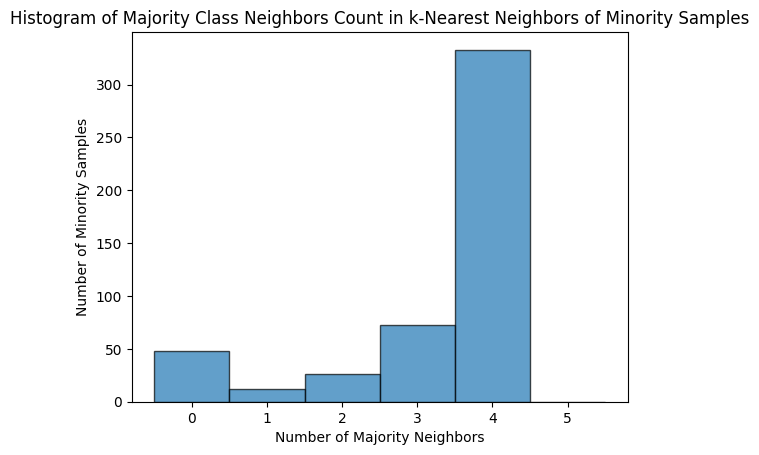

Number of minority samples with 0 majority neighbors: 48
Number of minority samples with 1 majority neighbors: 12
Number of minority samples with 2 majority neighbors: 26
Number of minority samples with 3 majority neighbors: 73
Number of minority samples with 4 majority neighbors: 333
Number of minority samples with 5 majority neighbors: 0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt



# Defining features and target variable
X = data.drop(columns=['isFraud']).values
y = data['isFraud'].values

# Identify minority and majority indices
minority_indices = np.where(y == 1)[0]
majority_indices = np.where(y == 0)[0]

# Check k-nearest neighbors
k = 5  # Number of neighbors
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
_, indices = nbrs.kneighbors(X[minority_indices])

# Calculate the count of majority samples in the k-nearest neighbors for each minority sample
majority_counts = [np.sum(y[neighbors] == 0) for neighbors in indices]

# Plot the histogram of majority counts
plt.hist(majority_counts, bins=range(k + 2), edgecolor='k', alpha=0.7, align='left')
plt.title('Histogram of Majority Class Neighbors Count in k-Nearest Neighbors of Minority Samples')
plt.xlabel('Number of Majority Neighbors')
plt.ylabel('Number of Minority Samples')
plt.xticks(range(k + 1))
plt.show()

# Print out the count of minority samples with each possible number of majority neighbors
for i in range(k + 1):
    count = np.sum(np.array(majority_counts) == i)
    print(f"Number of minority samples with {i} majority neighbors: {count}")